In [22]:
#  Converter DataLoader para iterador
data_iter = iter(train_dataloader)
# Pegar o primeiro lote
embeddings, lengths, targets = next(data_iter)
print(embeddings.shape,lengths.shape,targets.shape)

torch.Size([150, 2, 39, 2048]) torch.Size([150]) torch.Size([150])


In [48]:
embeddings, lengths, targets = next(data_iter)
print(embeddings.shape,lengths.shape,targets.shape)

torch.Size([150, 2, 45, 2048]) torch.Size([150, 2]) torch.Size([150])


In [36]:
#  Converter DataLoader para iterador
data_iter = iter(validation_dataloader)
# Pegar o primeiro lote
embeddings, lengths, targets = next(data_iter)
embeddings.shape

custom_collate_fn 150


torch.Size([150, 2, 55, 2048])

In [1]:
import torch
import gc

if not torch.cuda.is_available():
    print("CUDA is not available. Please ensure you have a compatible GPU and drivers installed.")
else:
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import torch
import numpy as np
from transformers import AutoTokenizer
import os

# Definir paralelismo corretamente
os.environ["TOKENIZERS_PARALLELISM"] = "true"

class TextToEmbedding:
    def __init__(self, weights_path, num_ids=128256, vector_size=2048, device='cpu'):
        """
        Inicializa a classe TextToEmbedding sem padding fixo.

        Args:
            weights_path (str): Caminho para o arquivo .npy que contém os pesos.
            num_ids (int, opcional): Número total de IDs. Padrão é 128256.
            vector_size (int, opcional): Tamanho de cada vetor de embedding. Padrão é 2048.
            device (str, opcional): Dispositivo para carregar os tensores ('cpu' ou 'cuda'). Padrão é 'cpu'.
        """
		
        self.device = device

        # Carrega o tokenizer sem padding fixo
        self.tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B", use_fast=True)
        
        # Carrega os pesos a partir do arquivo .npy
        try:
            weights_np = np.load(weights_path)
            self.weights = torch.from_numpy(weights_np).to(self.device)
        except FileNotFoundError:
            raise FileNotFoundError(f"O arquivo de pesos '{weights_path}' não foi encontrado.")
        except Exception as e:
            raise RuntimeError(f"Erro ao carregar os pesos: {e}")
        
        # Verifica a forma dos pesos
        if self.weights.shape != (num_ids, vector_size):
            raise ValueError(f"O formato do arquivo weights.npy é {self.weights.shape}, mas era esperado {(num_ids, vector_size)}.")

embedding_generator = TextToEmbedding("weights_half.npy", device='cpu')

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class SequenceDataset(Dataset):
	def __init__(self, df):
		"""
		Args:
			df (pd.DataFrame): Original DataFrame with columns ['content1', 'content2', 'target_transformed'].
		"""
		super(SequenceDataset, self).__init__()
		
		# Duplicate the data to include reversed examples
		#df_reversed = df.copy()
		#df_reversed[['content1', 'content2']] = df_reversed[['content2', 'content1']]
		#df_reversed['target_transformed'] = -df_reversed['target_transformed']
		
		# Concatenate original and reversed DataFrames
		#self.df_combined = pd.concat([df, df_reversed], ignore_index=True)
		

		
		# Reset index for safe indexing
		#self.df_combined.reset_index(drop=True, inplace=True)

		self.df = df

		# Normalize the target
		self.df['target_norm'] = self.df['target_transformed']

	def __len__(self):
		return len(self.df)

	def __getitem__(self, idx):
		"""
		Returns:
			dict: A dictionary containing 'content1', 'content2', and 'target_norm'.
		"""
		row = self.df.iloc[idx]
		return {
			'content1': row['content1'],
			'content2': row['content2'],
			'target_norm': row['target_norm']
		}

In [4]:
def custom_collate_fn(batch):
	"""
	Args:
		batch (list): List of individual data samples.
		embedding_generator: An object that provides tokenization and embedding functionalities.
		desvios_padrao (float): Standard deviation used for normalization.
	
	Returns:
		tuple: (embeddings, lengths, targets)
	"""
	# Extract lists from batch
	content1 = [item['content1'] for item in batch]
	content2 = [item['content2'] for item in batch]
	targets = [item['target_norm'] for item in batch]
	
	# Combine content1 and content2 for tokenization
	combined_contents = content1 + content2
	
	# Tokenization
	encoding = embedding_generator.tokenizer(
		combined_contents,
		return_tensors="pt",
		padding=True,
		truncation=True
	)
	
	num_original = len(batch)
	
	# Split the encodings back into two sets
	encoding1 = {key: value[:num_original] for key, value in encoding.items()}
	encoding2 = {key: value[num_original:] for key, value in encoding.items()}
	
	# Move to device
	device = embedding_generator.device
	input_ids1 = encoding1['input_ids'].to(device)
	attention_mask1 = encoding1['attention_mask'].to(device)
	input_ids2 = encoding2['input_ids'].to(device)
	attention_mask2 = encoding2['attention_mask'].to(device)
	
	# Obtain embeddings
	embeddings1 = embedding_generator.weights[input_ids1]  # Adjust based on your embedding generator
	embeddings2 = embedding_generator.weights[input_ids2]
	
	# Concatenate the two sequences along dimension 1
	embeddings = torch.stack([embeddings1, embeddings2], dim=1)  # Shape: (batch_size, 2, seq_length, vector_size)
	
	# Calcular comprimentos
	lengths1 = attention_mask1.sum(dim=1)
	lengths2 = attention_mask2.sum(dim=1)
	lengths = torch.stack([lengths1, lengths2], dim=1)  # (batch_size, 2)

	# Calcular comprimento combinado (máximo dos dois)
	combined_lengths = torch.max(lengths1, lengths2)

	# Obter índices ordenados em ordem decrescente de comprimento combinado
	sorted_idx = combined_lengths.argsort(descending=True)

	# Ordenar embeddings, comprimentos e targets
	embeddings = embeddings[sorted_idx]
	lengths = lengths[sorted_idx]
	targets = torch.tensor(targets, dtype=torch.float16)[sorted_idx]	
	
	return embeddings, lengths, targets

In [5]:
from datasets import load_dataset

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="train")

# Converter para DataFrame do pandas
df_training = pd.DataFrame({
    'content1': eval_dataset['sentence1'],
    'content2': eval_dataset['sentence2'],
    'target_transformed': eval_dataset['score']
})

training_dataset = SequenceDataset(df_training)
train_dataloader = DataLoader(
    training_dataset,
	batch_size=3, 
	num_workers=0,
	collate_fn=custom_collate_fn,
	pin_memory=False,
	shuffle=True,
	#persistent_workers=True
)

In [6]:
from datasets import load_dataset

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Converter para DataFrame do pandas
df_validation = pd.DataFrame({
    'content1': eval_dataset['sentence1'],
    'content2': eval_dataset['sentence2'],
    'target_transformed': eval_dataset['score']
})

validation_dataset = SequenceDataset(df_validation)
validation_dataloader = DataLoader(
    training_dataset,
	batch_size=3, 
	num_workers=0,
	collate_fn=custom_collate_fn,
	pin_memory=False,
	shuffle=True,
	#persistent_workers=True
)

In [7]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

class SequenceEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        """
        Inicializa o SequenceEncoder com LSTM bidirecional.

        Args:
            input_size (int): Dimensão da entrada de cada elemento da sequência.
            hidden_size (int): Tamanho do estado oculto do LSTM.
            num_layers (int): Número de camadas do LSTM.
        """
        super(SequenceEncoder, self).__init__()
        self.bidirectional = True  # Ativa o modo bidirecional
        self.num_directions = 2 if self.bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=0.3,
            batch_first=True,
            bidirectional=self.bidirectional  # Define como bidirecional
        )

    def forward(self, sequences, lengths):
        """
        Forward pass do SequenceEncoder.

        Args:
            sequences (Tensor): Tensor de sequências com forma [batch_size, seq_len, input_size].
            lengths (Tensor): Tensor de comprimentos com forma [batch_size].

        Returns:
            Tensor: Representação codificada das sequências com forma [batch_size, hidden_size * num_directions].
        """
        # Empacotar as sequências sem exigir ordenação
        packed_seq = rnn_utils.pack_padded_sequence(
            sequences,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False  # Permite sequências não ordenadas
        )

        # Passar pelo LSTM
        packed_output, (hn, cn) = self.lstm(packed_seq)

        if self.bidirectional:
            # hn tem forma [num_layers * 2, batch_size, hidden_size]
            # Separa os estados ocultos das direções forward e backward
            # e os concatena
            hn_forward = hn[-2]  # Última camada forward
            hn_backward = hn[-1]  # Última camada backward
            hn = torch.cat((hn_forward, hn_backward), dim=1)  # [batch_size, hidden_size * 2]
        else:
            hn = hn[-1]  # Forma: [batch_size, hidden_size]

        return hn  # [batch_size, hidden_size * num_directions]

In [8]:
class SiameseModel(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers, fc_hidden_sizes=[2048,2048,256,128]):
		"""
		Inicializa o SiameseModel com LSTM bidirecional.

		Args:
			input_size (int): Dimensão da entrada de cada elemento da sequência.
			hidden_size (int): Tamanho do estado oculto do LSTM.
			num_layers (int): Número de camadas do LSTM.
			fc_hidden_sizes (list of int): Tamanhos das camadas ocultas totalmente conectadas adicionais.
		"""
		super(SiameseModel, self).__init__()
		self.encoder = SequenceEncoder(input_size, hidden_size, num_layers)

		# Camadas totalmente conectadas para combinar as duas representações
		self.fc_layers = nn.ModuleList()
		input_dim = hidden_size * 2 * 2  # hidden_size * num_directions * 2 (para as duas sequências)

		for hidden_size_fc in fc_hidden_sizes:
			self.fc_layers.append(nn.Linear(input_dim, hidden_size_fc))
			self.fc_layers.append(nn.ReLU())
			input_dim = hidden_size_fc

		self.output_layer = nn.Linear(input_dim, 1)

	def forward(self, sequences, lengths):
		"""
		Forward pass para a rede Siamese.

		Args:
			sequences (Tensor): Tensor de embeddings com forma [batch_size, 2, seq_len, input_size].
			lengths (Tensor): Tensor de comprimentos com forma [batch_size, 2].

		Returns:
			Tensor: Predições de saída com forma [batch_size].
		"""
		# Dividir as sequências e os comprimentos para ambos os inputs
		seq1 = sequences[:, 0, :, :]  # Forma: [batch_size, seq_len, input_size]
		len1 = lengths[:, 0]           # Forma: [batch_size]
		out1 = self.encoder(seq1, len1)  # Forma: [batch_size, hidden_size * 2]

		seq2 = sequences[:, 1, :, :]  # Forma: [batch_size, seq_len, input_size]
		len2 = lengths[:, 1]           # Forma: [batch_size]
		out2 = self.encoder(seq2, len2)  # Forma: [batch_size, hidden_size * 2]

		# Combinar as duas representações
		combined = torch.cat([out1, out2], dim=1)  # Forma: [batch_size, hidden_size * 4]

		# Passar pelas camadas totalmente conectadas com ativação não-linear e dropout
		x = combined
		for layer in self.fc_layers:
			x = layer(x)

		out = self.output_layer(x)  # Forma: [batch_size, 1]

		return out.squeeze(1)  # Forma: [batch_size]

In [9]:
import pytorch_lightning as pl
from torch.optim.lr_scheduler import OneCycleLR

limit_train_batches=16
max_epochs=2000

class CustomHuberLoss(nn.Module):
	def __init__(self, delta=1.0):
		super(CustomHuberLoss, self).__init__()
		self.delta = delta
		self.loss = torch.nn.MSELoss() #nn.HuberLoss(delta=delta)

	def forward(self, output, target):
		# Verificar os sinais de output e target usando os limites fornecidos
		output_sign = (output <= negative_threshold).float() - (output >= positive_threshold).float()
		target_sign = (target <= negative_threshold).float() - (target >= positive_threshold).float()

		# Calcular a perda Huber normal
		loss = self.loss(output, target)

		# Verificar se o sinal de output é diferente de target
		sign_diff = (output_sign != target_sign).float()

		# Se os sinais forem diferentes, multiplicar a perda por 2
		adjusted_loss = loss * (1 + sign_diff) 

		return adjusted_loss.mean()

class SiameseModel_Lightning(pl.LightningModule):
	def __init__(self, input_size=2048, hidden_size=256, num_layers=3, lr=1e-3, max_lr=1e-2):
		super(SiameseModel_Lightning, self).__init__()
		self.save_hyperparameters()

		# Instanciar o modelo modificado
		self.model = SiameseModel(
			input_size=input_size,
			hidden_size=hidden_size,
			num_layers=num_layers,
		)

		# Função de perda
		self.criterion = torch.nn.MSELoss() #CustomHuberLoss()

	def forward(self, sequences, lengths):
		return self.model(sequences, lengths)
	
	def training_step(self, batch):
		embeddings, lengths, targets = batch  # embeddings: (batch_size, 2, seq_len, vector_size)
		embeddings = embeddings.to(self.device)
		lengths = lengths.to(self.device)
		targets = targets.to(self.device)

		# Passagem para frente
		outputs = self(embeddings, lengths)  # (batch_size,)

		# Computar a perda
		loss = self.criterion(outputs, targets)

		# Logar a perda de treinamento
		self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

		# Obter a taxa de aprendizado atual do primeiro grupo de parâmetros
		lr = self.optimizers().param_groups[0]['lr']
		# Logar a taxa de aprendizado
		self.log('lr', lr, on_step=True, on_epoch=False, prog_bar=True, logger=True)

		# Clear variables
		del embeddings, lengths, targets, outputs
		gc.collect()
		return loss

	def validation_step(self, batch):
		embeddings, lengths, targets = batch
		embeddings = embeddings.to(self.device)
		lengths = lengths.to(self.device)
		targets = targets.to(self.device)

		# Passagem para frente
		outputs = self(embeddings, lengths)

		# Computar a perda
		loss = self.criterion(outputs, targets)

		# Logar a perda de validação
		self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

	def configure_optimizers(self):
		# Otimizador Adam
		optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

		# Configuração do OneCycleLR
		scheduler = OneCycleLR(
			optimizer,
			max_lr=self.hparams.max_lr,
			total_steps=(max_epochs * limit_train_batches),
			anneal_strategy='cos',
			pct_start=0.3,
			cycle_momentum=True,
			base_momentum=0.85,
			max_momentum=0.95,
		)

		# Retornar otimizador e scheduler com interval definido para 'step'
		return {
			'optimizer': optimizer,
			'lr_scheduler': {
				'scheduler': scheduler,
				'interval': 'step',      # Atualiza a cada passo
				'frequency': 1,          # Frequência de atualização
			}
		}

In [10]:
from pytorch_lightning.loggers import TensorBoardLogger

# Instanciando o TensorBoardLogger
tensorboard_logger = TensorBoardLogger('tb_logs', name='model_name')

In [11]:
model = SiameseModel_Lightning()

In [12]:
#model = SiameseModel_Lightning.load_from_checkpoint('./checkpoints/best-checkpoint-v11.ckpt')

In [13]:
from pytorch_lightning.callbacks import ModelCheckpoint

# Definir callbacks, por exemplo, ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    precision=16,
    #gradient_clip_val=1.0,
    accelerator='auto',
    devices='auto',
    callbacks=[checkpoint_callback],
    accumulate_grad_batches=max_epochs,
    deterministic=False,
    limit_train_batches=limit_train_batches,
    log_every_n_steps=limit_train_batches,
    profiler="simple",
    logger=tensorboard_logger
)

/home/jadson/anaconda3/envs/pytorch/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# Iniciar o treinamento
trainer.fit(
    model,
    train_dataloaders=train_dataloader, #IterableDataset
    val_dataloaders=validation_dataloader #Dataset
)

validation_dataloader torch.Size([900, 2, 66, 2048]) torch.Size([900, 2]) torch.Size([900])


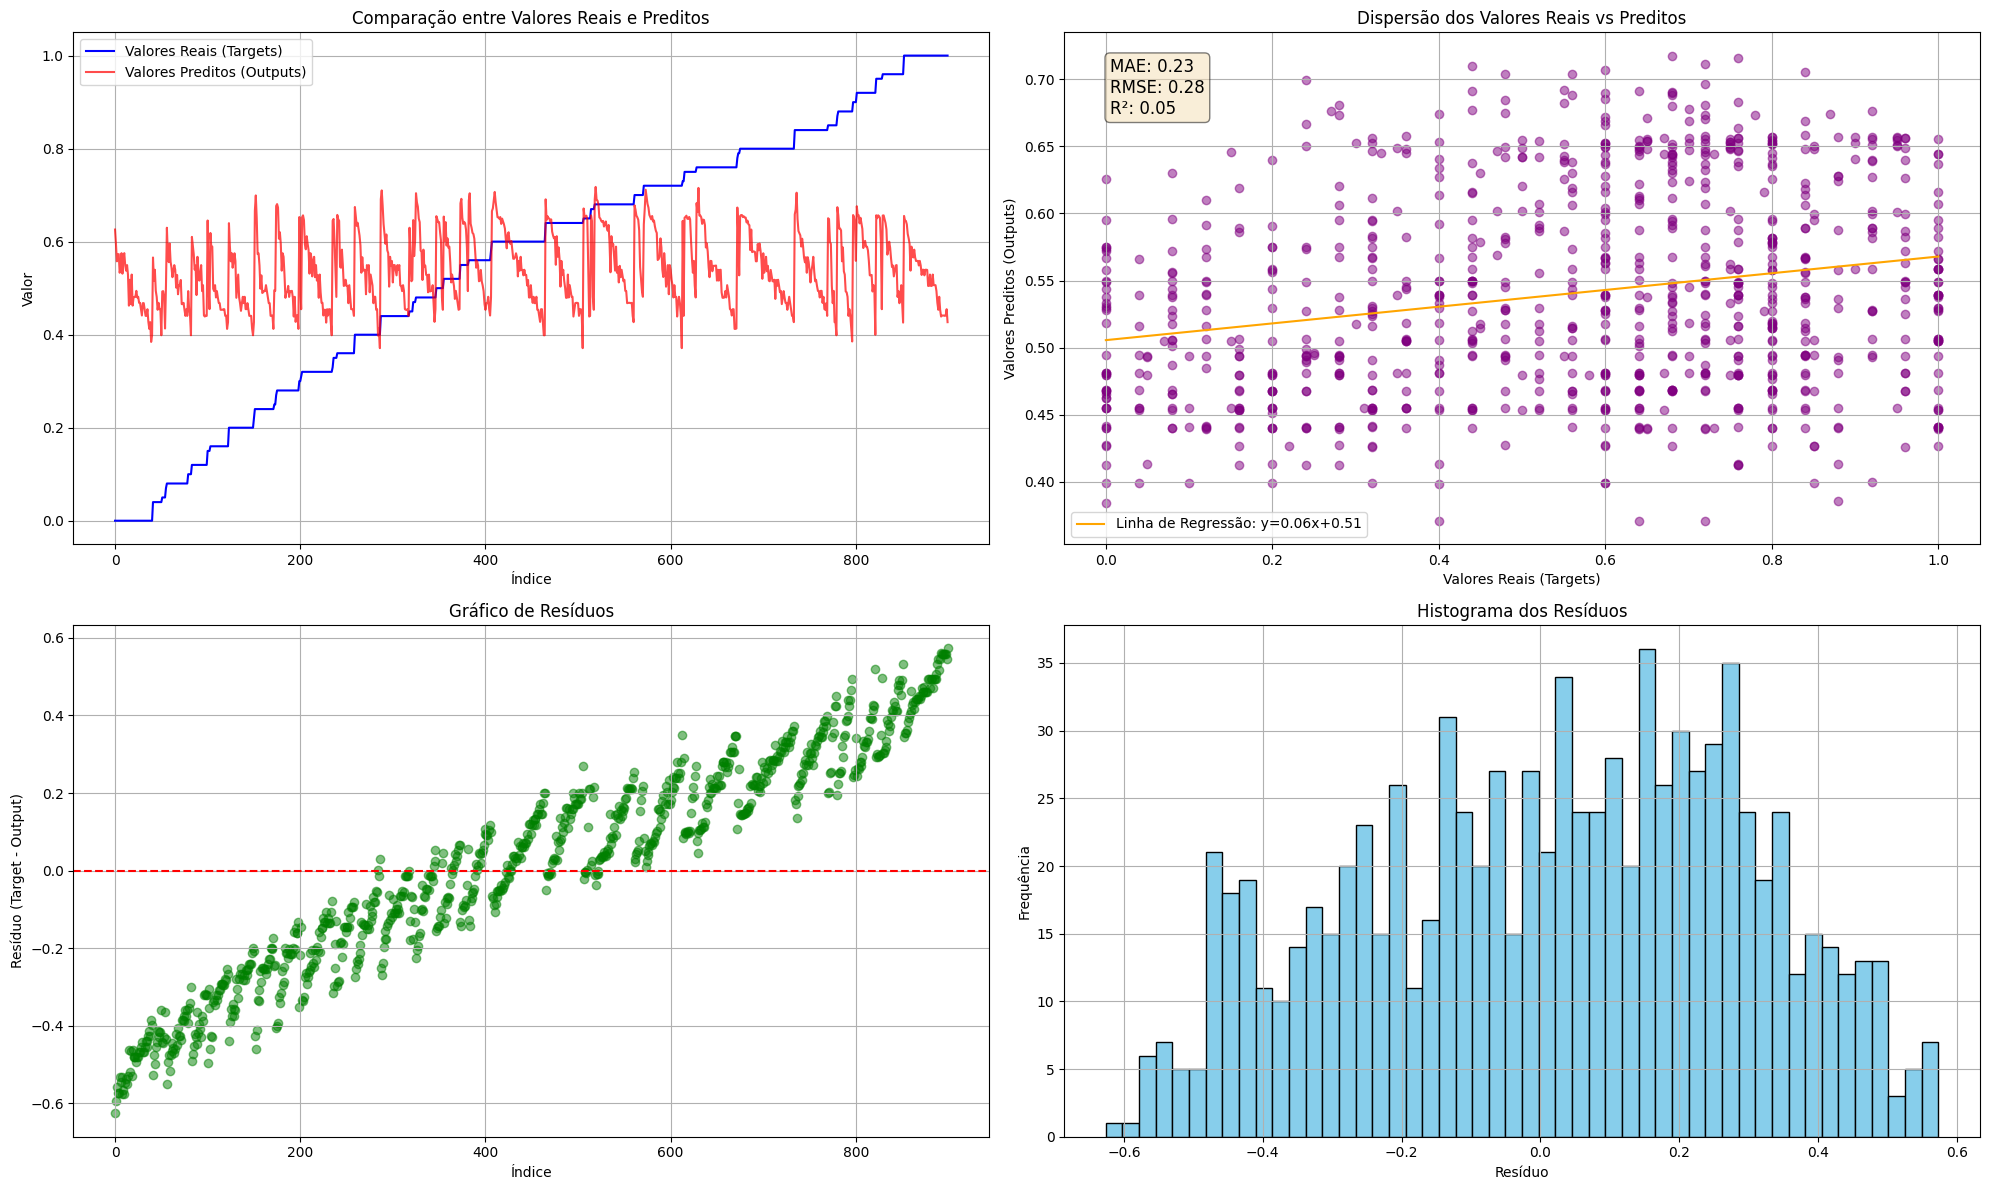

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Converter DataLoader para iterador
data_iter = iter(validation_dataloader)
# Pegar o primeiro lote
embeddings, lengths, targets = next(data_iter)
print("validation_dataloader", embeddings.shape, lengths.shape, targets.shape)

# Garantir os tipos de dados corretos
embeddings = embeddings.to(torch.float32).to('cuda')
lengths = lengths.to(torch.int64).to('cuda')
targets = targets.to(torch.float32).to('cuda')

model.to('cuda')
model.eval()

# Realizar a previsão
with torch.no_grad():
    output = model(embeddings, lengths)

# Ordenar os targets em ordem crescente e rearranjar os outputs de acordo
sorted_indices = targets.argsort(axis=0).flatten()  # Obter índices que ordenam os targets
targets_sorted = targets[sorted_indices]
output_sorted = output[sorted_indices]

# Aplicar a transformação inversa assinada usando .item()
targets_sorted_transformed = np.array([(t.item()) for t in targets_sorted])
output_sorted_transformed = np.array([(o.item()) for o in output_sorted])

# Calcular métricas de avaliação
mae = mean_absolute_error(targets_sorted_transformed, output_sorted_transformed)
rmse = np.sqrt(mean_squared_error(targets_sorted_transformed, output_sorted_transformed))
r2 = r2_score(targets_sorted_transformed, output_sorted_transformed)

# Criar uma figura com três subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# Gráfico 1: Comparação entre Valores Reais e Preditos
axes[0, 0].plot(targets_sorted_transformed, label='Valores Reais (Targets)', color='blue')
axes[0, 0].plot(output_sorted_transformed, label='Valores Preditos (Outputs)', color='red', alpha=0.7)
axes[0, 0].set_xlabel('Índice')
axes[0, 0].set_ylabel('Valor')
axes[0, 0].set_title('Comparação entre Valores Reais e Preditos')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Gráfico 2: Gráfico de Dispersão com Linha de Regressão
axes[0, 1].scatter(targets_sorted_transformed, output_sorted_transformed, alpha=0.5, color='purple')
# Linha de regressão
m, b = np.polyfit(targets_sorted_transformed, output_sorted_transformed, 1)
axes[0, 1].plot(targets_sorted_transformed, m * targets_sorted_transformed + b, color='orange', label=f'Linha de Regressão: y={m:.2f}x+{b:.2f}')
axes[0, 1].set_xlabel('Valores Reais (Targets)')
axes[0, 1].set_ylabel('Valores Preditos (Outputs)')
axes[0, 1].set_title('Dispersão dos Valores Reais vs Preditos')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Gráfico 3: Gráfico de Resíduos
residuals = targets_sorted_transformed - output_sorted_transformed
axes[1, 0].scatter(range(len(residuals)), residuals, alpha=0.5, color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Índice')
axes[1, 0].set_ylabel('Resíduo (Target - Output)')
axes[1, 0].set_title('Gráfico de Resíduos')
axes[1, 0].grid(True)

# Gráfico 4: Histograma dos Resíduos
axes[1, 1].hist(residuals, bins=50, color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('Resíduo')
axes[1, 1].set_ylabel('Frequência')
axes[1, 1].set_title('Histograma dos Resíduos')
axes[1, 1].grid(True)

# Adicionar métricas no gráfico de dispersão
metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}"
axes[0, 1].text(0.05, 0.95, metrics_text, transform=axes[0, 1].transAxes,
               fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Exibir a figura
plt.show()

In [15]:
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Listas para armazenar as pontuações reais e as previsões do modelo
true_scores = []
pred_scores = []

model.to('cuda')
model.eval()
with torch.no_grad():
	for example in eval_dataset:
		# Tokenização combinada
		encoding = embedding_generator.tokenizer(
			[example['sentence1'], example['sentence2']],
			return_tensors="pt",
			padding=True,  # Padding dinâmico
			truncation=True
		)

		# Converter para o dispositivo
		input_ids1 = encoding['input_ids'][0]
		attention_mask1 = encoding['attention_mask'][0]
		input_ids2 = encoding['input_ids'][1]
		attention_mask2 = encoding['attention_mask'][1]

		# Obter embeddings
		embeddings1 = embedding_generator.weights[input_ids1]
		embeddings2 = embedding_generator.weights[input_ids2]        
		
		# Concatenar as duas sequências no eixo 1
		embeddings = torch.stack([embeddings1, embeddings2]).float().unsqueeze(0).to('cuda')  # (batch_size, 2, seq_length, vector_size)
		
		# Calcular comprimentos
		lengths1 = attention_mask1.sum(dim=0)
		lengths2 = attention_mask2.sum(dim=0)
		lengths = torch.stack([lengths1, lengths2]).float().unsqueeze(0).to('cuda')  # (batch_size, 2)

		# Converter targets
		score = torch.tensor(example['score'], dtype=torch.float16).unsqueeze(0).to('cuda')  # (batch_size,)

		# Obter a previsão do modelo
		prediction = model(embeddings, lengths)

		# Armazenar as pontuações
		true_scores.append(score.item())
		pred_scores.append(prediction.item())

# Calcular as métricas de correlação
pearson_corr, _ = pearsonr(true_scores, pred_scores)
spearman_corr, _ = spearmanr(true_scores, pred_scores)

print("Similaridade Inversa da Diferença Absoluta")
print(f"Correlação de Pearson: {pearson_corr:.4f}")
print(f"Correlação de Spearman: {spearman_corr:.4f}")

Similaridade Inversa da Diferença Absoluta
Correlação de Pearson: 0.0200
Correlação de Spearman: 0.0257


In [12]:
# Converter DataLoader para iterador
data_iter = iter(validation_dataloader)
# Pegar o primeiro lote
embeddings, lengths, targets = next(data_iter)
print("validation_dataloader", embeddings.shape, lengths.shape, targets.shape)

# Garantir os tipos de dados corretos
embeddings = embeddings.to(torch.float32).to('cuda')
lengths = lengths.to(torch.int64).to('cuda')
targets = targets.to(torch.float32).to('cuda')

model = SiameseModel(
			input_size=2048,
			hidden_size=256,
			num_layers=3,
		)

model.to('cuda')
model.eval()
    
torch.onnx.export(
    model,
    (embeddings, lengths),
    "siamese_model.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['sequences', 'lengths'],
    output_names=['output'],
    dynamic_axes={
        'sequences': {0: 'batch_size', 2: 'seq_len'},
        'lengths': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

validation_dataloader torch.Size([3, 2, 13, 2048]) torch.Size([3, 2]) torch.Size([3])


[W1219 15:56:04.270043997 shape_type_inference.cpp:1995] Warning: The shape inference of prim::PackPadded type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
[W1219 15:56:04.271482430 shape_type_inference.cpp:1995] Warning: The shape inference of prim::PackPadded type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
/home/jadson/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
[W1219 15:56:04.291730892 shape_type_inference.cpp:1995] Warni